In [2]:
#!pip install transformers

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Importing the dataset
We'll use pandas to read the dataset and load it into a dataframe.

In [5]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/Judgement Classification/Mydata01.csv')

In [6]:
df.shape

(320, 2)

In [7]:
df.head()

,0,1
0,People from Pune are arrogant,0
1,I have often experienced lack of respect while...,1
2,Varanasi is super clean now!,0
3,Varanasi is much more clean now. I felt really...,1
4,Tamilians eat monotonous food.,0


Lets see how many sentences are labeled as "Judgemental" (value 0) and how many are labeled "Non Judgmental" (having the value 1)

In [8]:
df['1'].value_counts()

1    161
0    159
Name: 1, dtype: int64

## Loading the Pre-trained BERT model
Let's now load a pre-trained BERT model. 

In [9]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Right now, the variable `model` holds a pretrained distilBERT model -- a version of BERT that is smaller, but much faster and requiring a lot less memory.

## Model #1: Preparing the Dataset
Before we can hand our sentences to BERT, we need to so some minimal processing to put them in the format it requires.

### Tokenization
Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

In [10]:
tokenized = df['0'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))


In [11]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Our dataset is now in the `padded` variable, we can view its dimensions below:

In [12]:
np.array(padded).shape

(320, 41)

### Masking
If we directly send `padded` to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [13]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(320, 41)

In [14]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [15]:
features = last_hidden_states[0][:,0,:].numpy()

In [16]:
features.shape

(320, 768)

The labels indicating which sentence is positive and negative now go into the `labels` variable

In [17]:
labels = df['1']

## Model #2: Train/Test Split
Let's now split our datset into a training set and testing set (even though we're using 2,000 sentences from the SST2 training set).

In [18]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

# **Logistic Regression**

In [19]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 5.263252631578947}
best scrores:  0.8083333333333332


We now train the LogisticRegression model. If you've chosen to do the gridsearch, you can plug the value of C into the model declaration (e.g. `LogisticRegression(C=5.2)`).

In [20]:
lr_clf = LogisticRegression(random_state=42)#,C=5.2)
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
print("Logistic Regression Train Accuracy :",lr_clf.score(train_features, train_labels))
print("Logistic Regression Test Accuracy :",lr_clf.score(test_features, test_labels))

Logistic Regression Train Accuracy : 0.9666666666666667
Logistic Regression Test Accuracy : 0.8625


# Lets Check Precision , Recall and Confusion Matrix

In [23]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix

predictions = lr_clf.predict(test_features)

report = metrics.classification_report(test_labels, predictions,target_names=['Judgemental','Non Judgemental'])
print(report) 

confusion_matrix = confusion_matrix(test_labels, predictions)
print(confusion_matrix)

                 precision    recall  f1-score   support

    Judgemental       0.97      0.77      0.86        43
Non Judgemental       0.78      0.97      0.87        37

       accuracy                           0.86        80
      macro avg       0.88      0.87      0.86        80
   weighted avg       0.88      0.86      0.86        80

[[33 10]
 [ 1 36]]


# RoC and AUC of Logisitc Regression

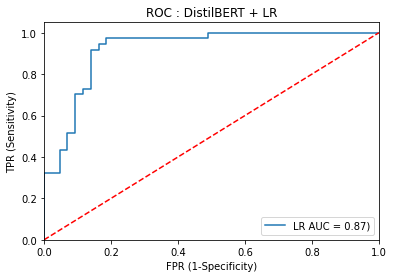

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

logit_roc_auc = roc_auc_score(test_labels, lr_clf.predict(test_features))
fpr, tpr, thresholds = roc_curve(test_labels, lr_clf.predict_proba(test_features)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='LR AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (1-Specificity)')
plt.ylabel('TPR (Sensitivity)')
plt.title('ROC : DistilBERT + LR')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# **Gaussin Naive Bayes**

In [25]:
model_NB = GaussianNB()
model_NB.fit(train_features, train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
print("Gaussian NB Train Accuracy :",model_NB.score(train_features, train_labels))
print("Gaussian NB Test Accuracy :",model_NB.score(test_features, test_labels))

Gaussian NB Train Accuracy : 0.7583333333333333
Gaussian NB Test Accuracy : 0.75


# Lets Check Precision , Recall and Confusion Matrix

In [27]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix

predictions = model_NB.predict(test_features)

report = metrics.classification_report(test_labels, predictions,target_names=['Judgemental','Non Judgemental'])
print(report) 

confusion_matrix = confusion_matrix(test_labels, predictions)
print(confusion_matrix)

                 precision    recall  f1-score   support

    Judgemental       0.77      0.77      0.77        43
Non Judgemental       0.73      0.73      0.73        37

       accuracy                           0.75        80
      macro avg       0.75      0.75      0.75        80
   weighted avg       0.75      0.75      0.75        80

[[33 10]
 [10 27]]


In [ ]:
#print(test_labels,predictions)

# RoC and AUC of Naive Bayes

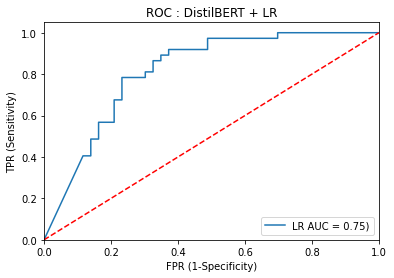

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

logit_roc_auc = roc_auc_score(test_labels, model_NB.predict(test_features))
fpr, tpr, thresholds = roc_curve(test_labels, model_NB.predict_proba(test_features)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='LR AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (1-Specificity)')
plt.ylabel('TPR (Sensitivity)')
plt.title('ROC : DistilBERT + LR')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# **Comparison of LR and NB**

In [29]:
print("Logistic Regression Train Accuracy :",lr_clf.score(train_features, train_labels))
print("Logistic Regression Test Accuracy :",lr_clf.score(test_features, test_labels))
print("Gaussian NB Train Accuracy :",model_NB.score(train_features, train_labels))
print("Gaussian NB Test Accuracy :",model_NB.score(test_features, test_labels))


Logistic Regression Train Accuracy : 0.9666666666666667
Logistic Regression Test Accuracy : 0.8625
Gaussian NB Train Accuracy : 0.7583333333333333
Gaussian NB Test Accuracy : 0.75


# **Our Decision**

We find Logisitic Regression is better fit here

# **Lets Validate it**


In [31]:
df_tst = pd.DataFrame(["I dont think he will be able to do that","Boys are dumb","New Delhi is the capital of India","Doing Yoga everyday keeps us fit"])
df_tst.shape

(4, 1)

In [32]:
#tokenized_tst = df_tst['Statement'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_tst = df_tst[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [33]:
max_len = 0
for i in tokenized_tst.values:
    if len(i) > max_len:
        max_len = len(i)

padded_tst = np.array([i + [0]*(max_len-len(i)) for i in tokenized_tst.values])

In [34]:
np.array(padded_tst).shape

(4, 13)

In [35]:
attention_mask_tst = np.where(padded_tst != 0, 1, 0)
attention_mask_tst.shape

(4, 13)

In [36]:
input_ids_tst = torch.tensor(padded_tst)  
attention_mask_tst = torch.tensor(attention_mask_tst)

with torch.no_grad():
    last_hidden_states_tst = model(input_ids_tst, attention_mask=attention_mask_tst)

In [37]:
features_tst = last_hidden_states_tst[0][:,0,:].numpy()

In [38]:
y_prob = lr_clf.predict_proba(features_tst)

In [39]:
y_prob

array([[0.87298594, 0.12701406],
       [0.97573595, 0.02426405],
       [0.07432295, 0.92567705],
       [0.8919436 , 0.1080564 ]])

In [40]:
predicted_indices = (y_prob[:, 1] > 0.5).astype(int)
predicted_indices

array([0, 0, 1, 0])

In [41]:
df_tst = np.array(df_tst)

In [42]:
labels = ['Judgemental','Non Judgemental']

In [43]:
for i, index in enumerate(predicted_indices):
    print(df_tst[i], " => ", labels[index], ' with ', 100*y_prob[i, index])

['I dont think he will be able to do that']  =>  Judgemental  with  87.29859368671632
['Boys are dumb']  =>  Judgemental  with  97.57359543590825
['New Delhi is the capital of India']  =>  Non Judgemental  with  92.56770513385308
['Doing Yoga everyday keeps us fit']  =>  Judgemental  with  89.19435959714033
